In [18]:
from pathlib import Path
import sys
pwd = str(Path("..").absolute())
sys.path.insert(0, pwd)

from Pyrser import pyrser
from Node import Node, FileNode, FncNode
from Utils.PyrserHelpers import xfs, dfs_generator
import graphviz; from graphviz import Digraph

In [19]:
file = "/home/kemri/Projects/pyrser"
output = pyrser(file)

In [20]:
output

DirNode(name='pyrser', location='/home/kemri/Projects/pyrser')
 |-- DirNode(name='.git', location='/home/kemri/Projects/pyrser/.git')
 |    |-- DirNode(name='branches', location='/home/kemri/Projects/pyrser/.git/branches')
 |    |-- DirNode(name='hooks', location='/home/kemri/Projects/pyrser/.git/hooks')
 |    |-- DirNode(name='info', location='/home/kemri/Projects/pyrser/.git/info')
 |    |-- DirNode(name='logs', location='/home/kemri/Projects/pyrser/.git/logs')
 |    |    |-- DirNode(name='refs', location='/home/kemri/Projects/pyrser/.git/logs/refs')
 |    |    |    |-- DirNode(name='heads', location='/home/kemri/Projects/pyrser/.git/logs/refs/heads')
 |    |    |    |-- DirNode(name='remotes', location='/home/kemri/Projects/pyrser/.git/logs/refs/remotes')
 |    |    |    |    |-- DirNode(name='origin', location='/home/kemri/Projects/pyrser/.git/logs/refs/remotes/origin')
 |    |-- DirNode(name='objects', location='/home/kemri/Projects/pyrser/.git/objects')
 |    |    |-- DirNode(nam

#### The rules
- if a node has children, create a subgraph with label=node_name
- for every node with a parent, add that node to the parent's subgraph
- if a node calls another node, create a directional edge from one to the other

For test2.py, traversing the Node tree, it would mean:
1. Hit FileNode: no parent && has children -> create subgraph
1. Hit FileNode.FncNode(test): has parent && no children -> add node to subgraph
1. Hit FileNode.FncNode(test2): has parent && has children -> create subgraph
1. Hit FileNode.FncNode(test2).FncNode(test2_1): has parent && no children -> add node to subgraph
1. no more nodes, return

In [21]:
def create_node(node: Node, graph: graphviz.dot.Digraph = None) -> graphviz.dot.Digraph:
    if graph is None:
        graph = Digraph(comment=node.name)
        
    if node.children:
        with graph.subgraph(name="cluster_"+node.name) as sg:
            for child in node.children:
                child_node = node.children[child]
                create_node(child_node, sg)
            sg.attr(label=node.name)
    else:
        graph.node(node.name, shape="box")
    
    return graph

In [22]:
def add_edges(node: Node, graph: graphviz.dot.Digraph) -> None:
    for n in dfs_generator(node):
        if type(n) != FncNode:
            continue
        
        if calls := n.calls:
            for call in calls:
                frm = n.name
                to = call.name
                graph.edge(frm, to)

In [23]:
test = create_node(output)

In [24]:
type(test)

graphviz.dot.Digraph

In [25]:
add_edges(output, test)

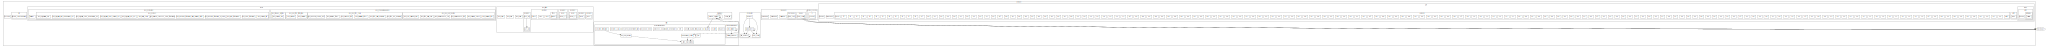

In [26]:
test